# Motivation
In this notebook, I want to *really* refine the methods that I was messing around with in **`02. Better Board Detection`**. 

Once I have the process streamlined a lot, I can run through some automated testing (since I've labeled a bunch of the pictures). 

# Setup
The cells below will set up the rest of this notebook. 

First, I'll configure the kernel: 

In [18]:
# Change directories to the root of the project
%cd ..

# Enable autoreload of modules
%load_ext autoreload
%autoreload 2

d:\data\programming\boggle-vision
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Next, I'll import some relevant libraries:

In [19]:
# Import statements
import cv2
import pandas as pd
from pathlib import Path
import math
from matplotlib import pyplot as plt
import numpy as np
from statistics import mode
import utils
import cv2
import pytesseract
from PIL import Image
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import torch

# Importing custom modules
import utils.board_detection as board_detect
from utils.cnn import BoggleCNN
from utils.settings import allowed_boggle_tiles
from utils.visual_filters import apply_canny_edge_detection

# Loading Data
Here, I'm going to load in all of the pictures, as well as some information about each of them. 

In [20]:
# Open the .csv file containing the labeled boards
board_data_df = pd.read_csv("data/labeled-boards.csv")

# Add a column which is the parsed letter sequence
board_data_df["parsed_letter_sequence"] = board_data_df["letter_sequence"].apply(
    lambda letter_list: letter_list.split(";")
)

# Load all of the images using cv2
file_path_to_image = {}
for row in board_data_df.itertuples():
    file_path_to_image[row.file_path] = cv2.imread(row.file_path)


KeyboardInterrupt



# Board Detection Process
Below, I'm going to run through the board detection process. 

Each step should generally try and follow these rules: 

- Be relatively discrete; some data structure will be passed into some methods, and some additional data structures will be passed out. 
- Mostly everything ought to be methodized and placed into `utils/board_detection.py`. 

### **Step 0:** Setting the Detection Process
Below, I'll declare a couple of settings for the board detection process. 

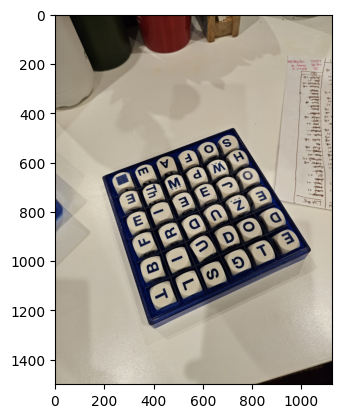

In [ ]:
# Parameterizing the board detection algorithm
max_image_height = 1500

# Indicating a test image to use
input_image_path = "data/test-pictures/easy-04.png"

# Load the image into memory
input_image = cv2.imread(input_image_path)

# Resize the image to a smaller size
input_image = board_detect.resize_image(input_image, max_image_height)

# Show the image
board_detect.show_cv2_image(input_image)

### **Step 1:** Locating the Board 

In this step, we'll run through some contour detection for locating the board. 

In [ ]:
# Parameterizing the method
n_top_contours_to_consider = 200
min_board_area_threshold = 0.15
max_board_area_threshold = 0.8
board_contour_expansion_size = 25
polygon_approximation_epsilon = 0.05
binary_threshold_value = 100

# Detect the board contour
boggle_board_contour = board_detect.detect_boggle_board_contour(
    input_image,
    n_top_contours_to_consider,
    min_board_area_threshold,
    max_board_area_threshold,
    board_contour_expansion_size,
    polygon_approximation_epsilon,
    binary_threshold_value,
)

Now that the board's been detected, we'll show the contour. 

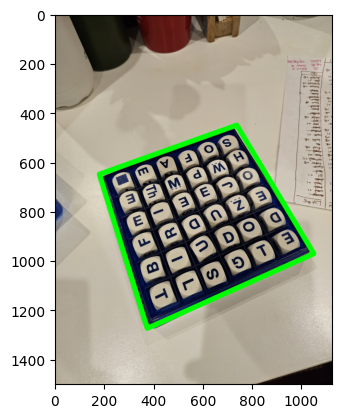

In [ ]:
board_detect.draw_contours(
    cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB),
    [boggle_board_contour],
    color=(0, 255, 0),
    thickness=20,
)

### **Step 2:** Warping Image Perspective
Next, we're going to use a method to warp the perspective of the image to a top-down view. This way, we'll get a clearer view of the board. 

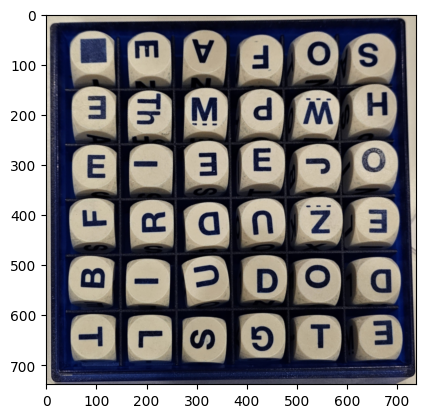

In [ ]:
# Warp the input image to get a top-down view of the board
top_down_board_image = board_detect.warp_perspective_to_top_down(
    input_image, boggle_board_contour
)

# Next, we'll show off what this looks like
board_detect.show_cv2_image(top_down_board_image)

### **Step 3:** Tile Contour Detection
Next up: I'm going to detect the contours of each of the letter tiles within the board.

In [ ]:
# Parameterizing the tile detection process
binary_threshold_value = 100
min_tile_area_percentage = 0.0003
max_tile_area_percentage = 0.02
tile_size_difference_threshold = 0.3
polygon_approximation_epsilon = 0.02

# Run the tile detection process
tile_contours_df, binary_image = board_detect.detect_tile_contours(
    top_down_board_image=top_down_board_image,
    binary_threshold_value=binary_threshold_value,
    min_tile_area_percentage=min_tile_area_percentage,
    max_tile_area_percentage=max_tile_area_percentage,
    tile_size_difference_threshold=tile_size_difference_threshold,
    return_binary_image=True
)

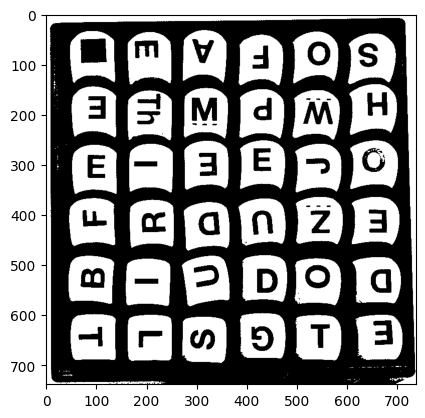

In [ ]:
plt.imshow(binary_image, cmap="gray")

Now that I've detected all of the contours in the image, I'm going to show them. 

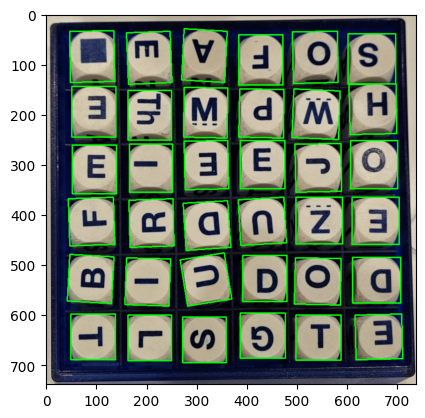

In [ ]:
board_detect.draw_contours(
    cv2.cvtColor(top_down_board_image, cv2.COLOR_BGR2RGB),
    list(tile_contours_df["contour"]),
    color=(0, 255, 0),
    thickness=2,
)

### **Step 4:** Tile Image Extraction
The next step is tile image extraction. Here, we're going to to try and extract an image corresponding with each tile, and then clean up the image! 

In [ ]:
# Parameterize this method
min_contour_pct_of_total_area = 0.003
polygon_approximation_epsilon = 0.01
min_contour_in_underline = 2
binary_threshold_value = 200
adaptive_threshold_kernel_size_relative = 0.015
adaptive_threshold_C = 5
resize_size = 100

# Run the tile extraction method
extracted_tile_img_dict, special_tile_info = board_detect.extract_tile_images(
    top_down_board_image=top_down_board_image,
    tile_contours_df=tile_contours_df,
    min_contour_pct_of_total_area=min_contour_pct_of_total_area,
    polygon_approximation_epsilon=polygon_approximation_epsilon,
    min_contour_in_underline=min_contour_in_underline,
    adaptive_threshold_kernel_size_relative=adaptive_threshold_kernel_size_relative,
    adaptive_threshold_C=adaptive_threshold_C,
    resize_size=resize_size,
)

Now that we've extracted each of the tile images, we'll show them. 

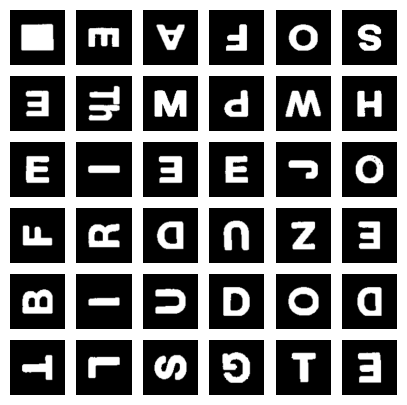

In [ ]:
# Extract a list of the images from the dictionary
tile_images_list = [image for tile_idx, image in extracted_tile_img_dict.items()]

# Display the images in a grid
board_detect.display_images_in_grid(
    tile_images_list, grid_size=int(math.sqrt(len(tile_images_list)))
)

I'll also print some information about the tiles that we've identified as being special: 

In [ ]:
special_tile_info

### **Step 5a:** Tile OCR
Finally, the last step of the process: running some OCR on each of the tiles. 

In [ ]:
# Set up the EasyOCR reader
import easyocr
reader = easyocr.Reader(['en'], gpu=False)

# Run the OCR on the tiles
tile_ocr_results_df = board_detect.ocr_all_tiles(extracted_tile_img_dict, special_tile_info, 
                                                 skeletonize=True,
                                                 easyocr_reader=reader)

Using CPU. Note: This module is much faster with a GPU.
d:\data\programming\boggle-vision\boggle-vision-prototyping\utils\board_detection.py:1363: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(df_result_list)
d:\data\programming\boggle-vision\boggle-vision-prototyping\utils\board_detection.py:1363: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(df_result_list)
d:\data\programming\boggle-vision\boggle-vision-prototyping\utils\board_detection.py:1363: FutureWarning

KeyboardInterrupt: 

What are the predicted letters? 

In [ ]:
# Print all of the predicted 
tiles_per_row = int(math.sqrt(len(tile_ocr_results_df)))
for cur_row in range(tiles_per_row):
    cur_df_subset = tile_ocr_results_df[
        cur_row * tiles_per_row : (cur_row + 1) * tiles_per_row
    ]
    print("; ".join(cur_df_subset["letter"].tolist()))

### **Step 5b:** Tile OCR (Self-Trained CNN)
I trained my own CNN on some Boggle data I extracted. Below, I'm going to write a method that runs the OCR using this model. 

In [31]:
# Load in the model at models/boggle_cnn.pth
net = BoggleCNN()
net.load_state_dict(torch.load("boggle-vision-prototyping/models/boggle_cnn.pth"))

# Run the CNN on the tiles
tile_cnn_results_df = board_detect.ocr_all_tiles_cnn(extracted_tile_img_dict, net)

torch.Size([4, 100, 100])
torch.Size([4, 100, 100])
torch.Size([4, 100, 100])
torch.Size([4, 100, 100])
torch.Size([4, 100, 100])
torch.Size([4, 100, 100])
torch.Size([4, 100, 100])
torch.Size([4, 100, 100])
torch.Size([4, 100, 100])


Now that I've got this, I'm going to print the results:

In [29]:
# Print all of the predicted 
tiles_per_row = int(math.sqrt(len(tile_cnn_results_df)))
for cur_row in range(tiles_per_row):
    cur_df_subset = tile_cnn_results_df[
        cur_row * tiles_per_row : (cur_row + 1) * tiles_per_row
    ]
    print("; ".join(cur_df_subset["letter"].tolist()))

BLOCK; E; A; F; O; S
E; Th; M; P; W; H
E; I; E; E; J; O
F; R; D; U; Z; E
B; I; U; D; O; D
T; L; S; G; T; E


# Combining Steps Into a Method

In [ ]:
board_detect.parse_boggle_board(input_image, easyocr_reader=reader)

In [35]:
import torch
import torch.onnx
from utils.cnn import BoggleCNN

# Load your model
model = BoggleCNN()
model.load_state_dict(torch.load("boggle-vision-prototyping/models/boggle_cnn.pth"))
model.eval()  # Set the model to evaluation mode

# Create a dummy input tensor
dummy_input = torch.randn(1, 1, 100, 100)  # Modify the size according to your input

# Export the model to ONNX
torch.onnx.export(model, dummy_input, "model.onnx", verbose=True)

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
|